In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from dask.distributed import Client

In [2]:
# HELPER

def get_wv_idx(path, wv):
    dt = xr.open_datatree(path)
    return dt["sensor_band_parameters"].wavelength3d.get_index("wavelength3d").get_loc(wv)

def time_from_attr(ds):
    """Set the start time attribute as a dataset variable.

    Parameters
    ----------
    ds
        a dataset corresponding to a Level-2 granule
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["time"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("time")
    return ds

def grid_match(path, dst_crs, dst_shape, dst_transform, var, wv_idx=None):
    geoloc_group_name = 'geolocation_data'
    
    """Reproject a Level-2 granule to match a Level-3M-ish granule."""
    dt = xr.open_datatree(path)
   
    
    if "geophysical_data" in dt:
        da = dt["geophysical_data"]
    elif "navigation_data" in dt:
        da = dt["navigation_data"]
    else:
        da = None  # or raise an error / handle differently
        
        
    da = da[var]
    if wv_idx is not None:
        if "wavelength3d" in da.dims:
            da = da.sel(wavelength3d=wv_idx)
        elif "Wavelength_Used_all" in da.dims:
            da = da.sel(Wavelength_Used_all=wv_idx)
        else:
            raise KeyError("Neither 'wavelength3d' nor 'Wavelength_Used_all' found in dataset.")
    da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    da = da.rio.set_crs("epsg:4326")
    da = da.rio.reproject(
        dst_crs,
        shape=dst_shape,
        transform=dst_transform,
        src_geoloc_array=(
            dt[geoloc_group_name]["longitude"],
            dt[geoloc_group_name]["latitude"],
        ),
    )
    da = da.rename({"x":"longitude", "y":"latitude"})
    return da

def crs_template(path, var, wv=None):
    datatree = xr.open_datatree(path)

    dataset = xr.merge(datatree.to_dict().values())
    dataset = dataset.set_coords(("latitude", "longitude"))
    da = dataset[var]
    if wv is not None:
        if "wavelength3d" in da.dims:
            da = da.sel(wavelength3d=wv)
        elif "Wavelength_Used_all" in da.dims:
            da = da.sel(Wavelength_Used_all=wv)
        else:
            raise KeyError("Neither 'wavelength3d' nor 'Wavelength_Used_all' found in dataset.")

    da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    da = da.rio.write_crs("epsg:4326")
    da_L3M = da.rio.reproject(
        dst_crs="epsg:4326",
        src_geoloc_array=(
            da.coords["longitude"],
            da.coords["latitude"],
        ),
    )
    da_L3M = da_L3M.rename({"x":"longitude", "y":"latitude"})
    return da_L3M.rio.crs, da_L3M.rio.shape, da_L3M.rio.transform()

def grid_aligned_subset(bbox, transform, shape):
    from affine import Affine
    """
    mid: (lon, lat)
    ext: half-size in degrees (so box is lon±ext, lat±ext)
    transform: source Affine from crs_template
    shape: (height, width) from crs_template
    returns: (new_shape, new_transform, window_indices)
    """
    height, width = shape
    lon_min, lat_min, lon_max, lat_max = bbox

    # Map bounds to fractional pixel indices on the source grid
    inv = ~transform
    # upper-left of box -> (col,row)
    c0, r0 = inv * (lon_min, lat_max)
    # lower-right of box -> (col,row)
    c1, r1 = inv * (lon_max, lat_min)

    # Snap to integer pixel edges (expand to cover the whole region)
    col_off = int(np.floor(c0))
    row_off = int(np.floor(r0))
    col_max = int(np.ceil(c1))
    row_max = int(np.ceil(r1))

    # Clamp the *max* values, not the offsets

    cols = max(0, col_max - col_off)
    rows = max(0, row_max - row_off)

    # New transform is the old one shifted by the window offset
    new_transform = transform * Affine.translation(col_off, row_off)
    new_shape = (rows, cols)

    # Window indices you can use to slice arrays
    window = dict(row_off=row_off, col_off=col_off, height=rows, width=cols)
    return new_shape, new_transform, window


In [3]:
client = Client()
auth = earthaccess.login("../login.netrc")

In [4]:
# --- TIME ---

tspan = ("2024-09-01 00:00", "2025-03-01 00:00")

# --- REGION ---

# 42.69174831596751, 21.058555012396997
region = (41.7, 20.36, 43.7, 22.06)
mid = (21.058555012396997, 42.69174831596751)
ext = 1
region = (mid[0] - ext , mid[1] - ext, mid[0] + ext, mid[1] + ext)
region

(20.058555012396997, 41.69174831596751, 22.058555012396997, 43.69174831596751)

In [5]:
results_spx = earthaccess.search_data(
    short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
    cloud_hosted=True,
    bounding_box=region,
    temporal=tspan,
)
paths_spx = earthaccess.open(results_spx)

QUEUEING TASKS | :   0%|          | 0/33 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/33 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/33 [00:00<?, ?it/s]

In [6]:
results_oci = earthaccess.search_data(
    short_name="PACE_OCI_L2_AER_UAA",
    cloud_hosted=True,
    bounding_box=region,
    temporal=tspan,
)
paths_oci = earthaccess.open(results_oci)

QUEUEING TASKS | :   0%|          | 0/286 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/286 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/286 [00:00<?, ?it/s]

In [7]:
wv = 550
wv_idx = get_wv_idx(paths_spx[0], wv)
crs, shape_tmp, transform_tmp = crs_template(paths_spx[0], "aot", wv)
# Select best data set who covers the most region for the study of interest
shape, transform, _ = grid_aligned_subset(region, transform_tmp, shape_tmp)

In [8]:

kwargs = {"combine": "nested", "concat_dim": "time"}
attrs = xr.open_mfdataset(paths_spx, preprocess=time_from_attr, **kwargs)
futures = client.map(
    grid_match,
    paths_spx,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="aot",
    wv_idx=wv_idx
)
da_spx = xr.combine_nested(client.gather(futures), concat_dim="time")
da_spx["time"] = attrs["time"]

In [9]:
wv = 550
wv_idx = 550
crs, shape_tmp, transform_tmp = crs_template(paths_oci[0], "Aerosol_Optical_Depth", wv)
# Select best data set who covers the most region for the study of interest
shape, transform, _ = grid_aligned_subset(region, transform_tmp, shape_tmp)

In [10]:

kwargs = {"combine": "nested", "concat_dim": "time"}
attrs = xr.open_mfdataset(paths_oci, preprocess=time_from_attr, **kwargs)
futures = client.map(
    grid_match,
    paths_oci,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="Aerosol_Optical_Depth",
    wv_idx=wv_idx
)
da_oci = xr.combine_nested(client.gather(futures), concat_dim="time")
da_oci["time"] = attrs["time"]

In [15]:
#da_oci_matched = da_oci.reindex(
#    time=da_spx.time,
#    method="nearest",
#    tolerance="3H"
#)

da_oci_time_matched = da_oci.interp(time=da_spx["time"], method="nearest")
da_oci_matched = da_oci_time_matched.interp(
    longitude=da_spx["longitude"],
    latitude=da_spx["latitude"],
    method="linear"
)


In [ ]:
nc_path='/home/jovyan/nc_files'
da_spx.to_netcdf(f"{nc_path}/spx_aod.nc")
da_oci.to_netcdf(f"{nc_path}/oci_aod.nc")
da_oci_matched.to_netcdf(f"{nc_path}/oci_spx_aod.nc")

da_oci_time_matched.to_netcdf(f"{nc_path}/oci_spxTime_aod.nc")

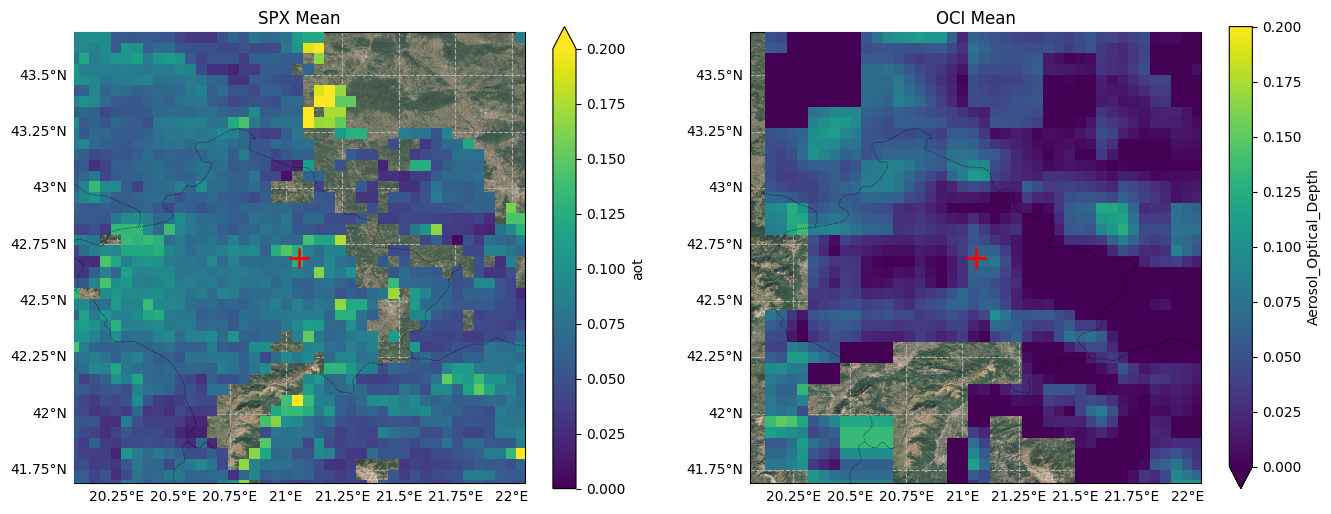

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

cross_lonlat = (21.058555012396997, 42.69174831596751)
cln, clt = cross_lonlat

tiler = cimgt.GoogleTiles(style="satellite")

fig, axes = plt.subplots(
    1, 2,  # 1 row, 2 columns
    figsize=(16, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for ax, da, title in zip(
    axes,
    [da_spx.mean("time"), da_oci_matched.mean("time")],
    ["SPX Mean", "OCI Mean"]
):
    ax.set_extent([region[0], region[2], region[1], region[3]], crs=ccrs.PlateCarree())
    ax.add_image(tiler, 12)

    ax.coastlines(resolution="110m", color="black", linewidth=0.6, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.2, zorder=1)

    da.plot.imshow(
        ax=ax,
        transform=ccrs.PlateCarree(),
        robust=True,
        cmap="viridis",
        vmin=0.0, vmax=0.2,   # you might want to standardize for comparison
        zorder=3
    )

    # gridlines
    gl = ax.gridlines(draw_labels=True, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False

    # marker
    ax.plot(
        cln, clt, transform=ccrs.PlateCarree(),
        marker="+", markersize=14, mew=2, mec="red", mfc="none",
        linestyle="none", zorder=4
    )

    ax.set_title(title)

#plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/movies'

Error in callback <function _draw_all_if_interactive at 0x7f5eb51fbd80> (for post_execute), with arguments args (),kwargs {}:


TypeError: Invalid shape (1892,) for image data

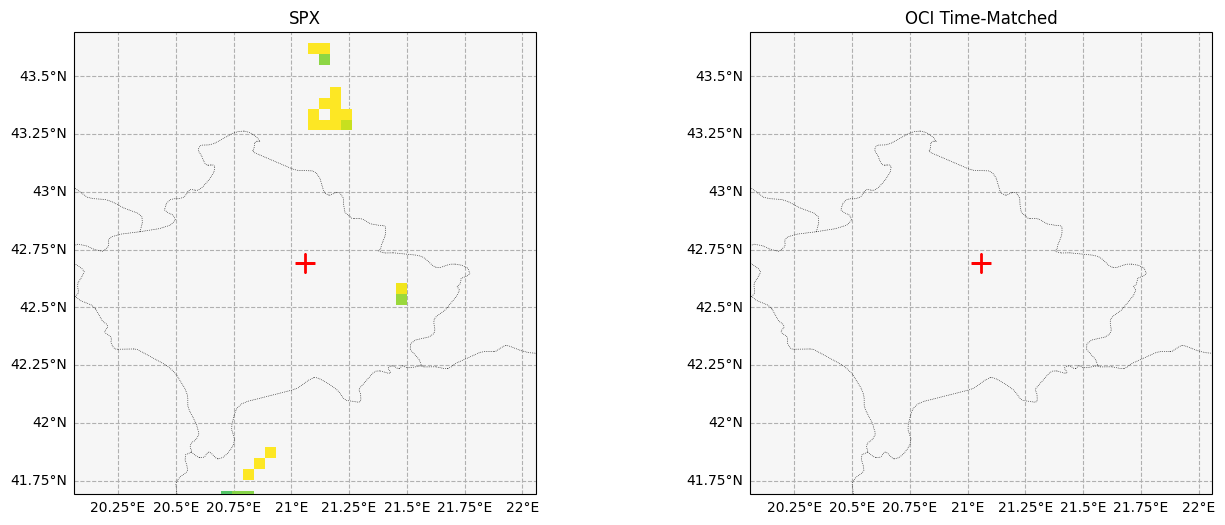

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Cross marker
cross_lonlat = (21.058555012396997, 42.69174831596751)
cln, clt = cross_lonlat

# Create figure with 2 subplots
fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Initialize plots for first frame (time=0)
ims = []
for ax, da, title in zip(
    axes,
    [da_spx, da_oci_time_matched],
    ["SPX", "OCI Time-Matched"]
):
    ax.set_extent([region[0], region[2], region[1], region[3]], crs=ccrs.PlateCarree())

    ax.coastlines(resolution="110m", color="black", linewidth=0.6, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.2, zorder=1)

    im = da.isel(time=0).plot.imshow(
        ax=ax,
        transform=ccrs.PlateCarree(),
        robust=True,
        cmap="viridis",
        vmin=0.0, vmax=0.2,
        add_colorbar=False,  # avoid duplicate colorbars
        zorder=3
    )
    ims.append(im)

    # gridlines
    gl = ax.gridlines(draw_labels=True, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False

    # marker
    ax.plot(
        cln, clt, transform=ccrs.PlateCarree(),
        marker="+", markersize=14, mew=2, mec="red", mfc="none",
        linestyle="none", zorder=4
    )

    ax.set_title(title)

# Update function for animation
def update(frame):
    ims[0].set_array(da_spx.isel(time=frame).values.ravel())
    ims[1].set_array(da_oci_time_matched.isel(time=frame).values.ravel())
    fig.suptitle(f"Time = {str(da_spx.time.values[frame])}")
    return ims

# Build animation
ani = animation.FuncAnimation(
    fig, update, frames=len(da_spx.time), interval=300, blit=False
)

# Save animation (choose one)
# ani.save("comparison.mp4", writer="ffmpeg", dpi=150)
ani.save("movies/spx_oci_comparison.gif", writer="pillow", dpi=120)

plt.show()